In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import math
from ordered_set import OrderedSet
np.seterr(divide = 'ignore') 
np.seterr(over="ignore")
np.seterr(all="ignore")
np.seterr(under="ignore")
np.seterr(invalid="ignore")
from pathlib import Path  


In [2]:
cd ..

/Users/helensiavelis/Desktop/Caltech/Senior/Spring 2023/CS 145/CS-145


In [3]:
cd MarketMaven/data

/Users/helensiavelis/Desktop/Caltech/Senior/Spring 2023/CS 145/CS-145/MarketMaven/data


# NYSE, NASDAQ, AMEX Graph

In [70]:
data = pd.read_csv('monthly_stock.csv')
remove_indexes = data[data['returns'] == 0].index
data.drop(remove_indexes, inplace=True)

In [71]:
remove_indexes = data[(data['exchange'] != 'AMEX')].index
data.drop(remove_indexes, inplace=True)

In [72]:
set(data.exchange.values)

{'AMEX'}

In [73]:
data = data.drop("monthly_transaction_id", axis=1)
data = data.drop("price", axis=1)
data = data.drop("shares_outstanding", axis=1)
data = data.drop("share_type", axis=1)
data = data.drop("exchange", axis=1)

In [74]:
## drop out any stocks that are not currently in the database
# find the last index of each permno. if not in 2020-12-31, drop it 
for permno in set(data['permno'].values):
    last_index = data[data['permno'] == permno].tail(1)
    if last_index['date'].item() < '2020-12-31':
        remove_indexes = data[data['permno'] == permno].index
        data.drop(remove_indexes, inplace=True)
    

In [75]:
## Adds an edge if the correlation is greater than or equal to theta
def add_correlation_edges(graph, permnos, theta):
    for i in permnos:
        permno_i_data = data[data['permno']== i]
        for j in permnos:
            permno_j_data = data[data['permno']== j]
            intersection = list(OrderedSet(list(permno_i_data['date'].values)) & OrderedSet(list(permno_j_data['date'].values)))
            returns_i = list(permno_i_data[permno_i_data['date'].isin(intersection)]['returns'].values)
            returns_j = list(permno_j_data[permno_j_data['date'].isin(intersection)]['returns'].values)
            curr_corr = np.corrcoef(returns_i, returns_j)[1, 0]
            if i != j and abs(curr_corr) > theta:
                graph.add_edge(i, j)
    return graph
            
            

In [76]:
## Create a graph here and add all nodes 
g = nx.Graph()
g.add_nodes_from(list(set(data['permno'].values)))
g = add_correlation_edges(g, list(g.nodes), .9)
g.remove_nodes_from(list(nx.isolates(g)))

/Users/helensiavelis/miniforge3/lib/python3.9/site-packages/numpy/lib/function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)


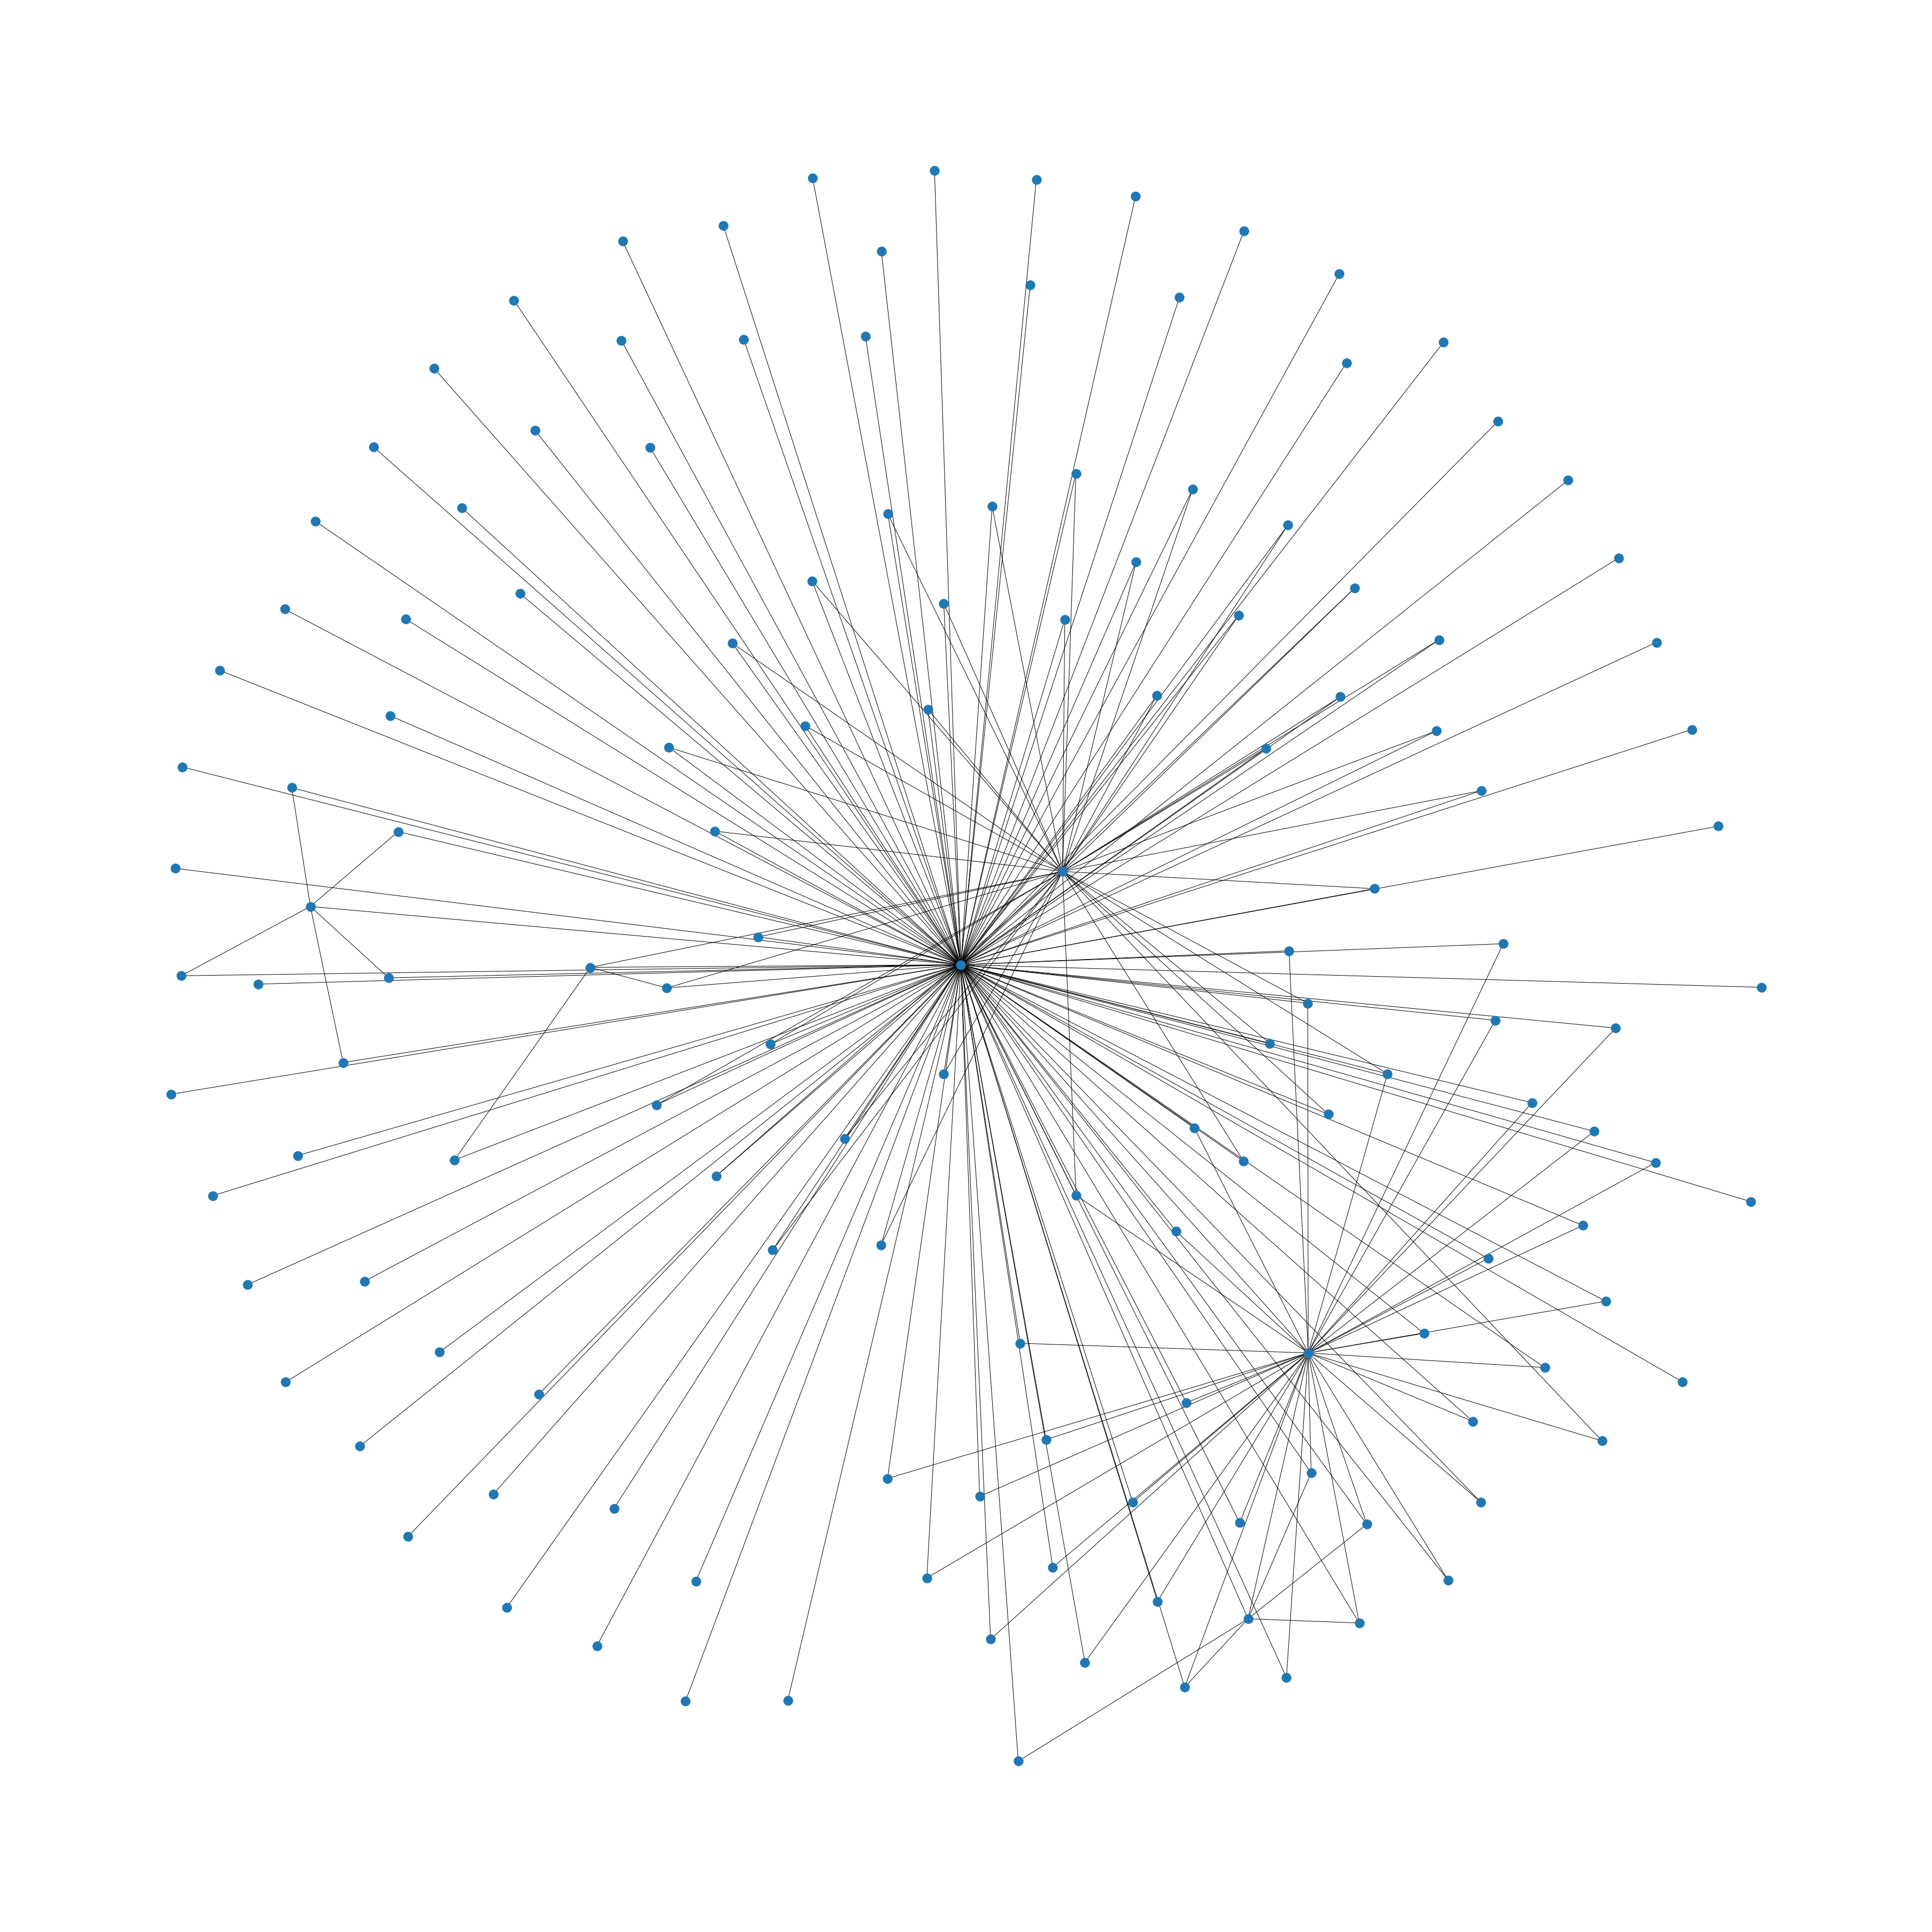

In [77]:
plt.figure(figsize=(50, 50))
nx.draw_spring(g)

In [78]:
## convert graph to pandas adjacency list 
aj = nx.to_pandas_adjacency(g)

In [79]:
ls

adj_matrix.csv                   adj_matrix_NYSE_NASDAQ_AMEX.csv
adj_matrix_NASDAQ.csv            current_crsp_tickers.csv
adj_matrix_NASDAQ_AMEX.csv       monthly_stock.csv
adj_matrix_NYSE.csv              monthly_stock_ffm.csv


In [80]:
## write csv as pandas adjancey list 
filepath = Path('adj_matrix_AMEX.csv')  
aj.to_csv(filepath)

# Portfolios and Analysis 

In [ ]:
## Optimization problem for centrality coefficients 
def solve_optimization_problem():
    return 1/3  

In [ ]:
## Find the average centralities of all stocks
def find_average_centralities(graph):
    average_centrailites = dict()
    scale_factor = solve_optimization_problem()
    
    degree_centrality = nx.degree_centrality(graph)
    closeness_centrality = nx.closeness_centrality(graph)
    betweenness_centrality = nx.betweenness_centrality(graph)
    for node in graph.nodes():
        average_centrailites[node] = scale_factor * (degree_centrality[node] + closeness_centrality[node] + betweenness_centrality[node])        
    return average_centrailites

In [ ]:
## return the long and short stocks
def get_long_short_stocks(top_percent, graph, c_avgs):
    
    ## add centralities into the graph 
    
    sorted_c_avgs_top = sorted(c_avgs, key=c_avgs.get, reverse=True)
    sorted_c_avgs_bottom = sorted(c_avgs, key=c_avgs.get, reverse=False)
    
    
    
    top_stocks = math.floor(top_percent * len(sorted_c_avgs_top))
    bottom_stocks = math.floor(top_percent * len(sorted_c_avgs_bottom))
    return sorted_c_avgs_top[:top_stocks], sorted_c_avgs_bottom[:bottom_stocks]


In [ ]:
average_centralities = find_average_centralities(g)
## enter centralities into the current dataframe 

In [ ]:
average_centralities

In [ ]:
data

In [ ]:
long, short = get_long_short_stocks(.10, g, average_centralities)
nodes_to_keep = long + short 


In [ ]:
nodes_to_remove = [node for node in list(g.nodes) if node not in nodes_to_keep]
print(len(nodes_to_remove))

In [ ]:
#### remove all nodes from g that are not in the long short (COPIED VERSION)
g_copy = g.copy()
g_copy.remove_nodes_from(nodes_to_remove)
g_copy.remove_nodes_from(list(nx.isolates(g_copy)))

In [ ]:
plt.figure(figsize=(25, 25))
nx.draw(g_copy)

In [ ]:
## clean FFM 

In [ ]:
## CAPM
model = smf.ols(formula='EQ_RF ~ Mkt_RF', data=merged_data).fit()
print(f"P Value: {model.pvalues[0]}")
print(f"Beta of the EQ Stratgey: {model.params[1]}")
print(f"Alpha of the EQ Stratgey: {model.params[0]}")   
beta_VAL = model.params[1]

In [ ]:
implied_returns = merged_data['RF'] + beta_VAL * merged_data['Mkt_RF']
plt.figure()
plt.plot(merged_data['date'], (1 + merged_data['VAL']/100).cumprod() - 1)
plt.plot(merged_data['date'], (1 + merged_data['Mkt']/100).cumprod() - 1)
plt.plot(merged_data['date'], (1 + implied_returns/100).cumprod() - 1)

plt.xlabel("Date (Months)")
plt.ylabel("Returns")
plt.title("Cumulative Returns")
plt.legend(['VAL Strategy', 'Market', 'Implied Returns'])
plt.show() 